# Sentinel-2 Satellite Analysis for Major Global Ports With an end goal of capturing Trading Signals based on Post Tarriffs Output on China and The EU

This notebook implements the satellite image analysis system described in the research to:
1. Collect satellite imagery from major ports
2. Use deep learning to count shipping containers
3. Generate trading signals from container volume changes

In [5]:
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import ee
import torch
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import requests
from PIL import Image
from io import BytesIO
import pynvml
import cv2
from gee_collector import GoogleEarthCollector
import os
import torch

# Load the trained model and use the one with the best weights : best.pt


In [6]:

# Load best trained model
model_path = 'runs/detect/train/weights/best.pt'
model = YOLO(model_path)

print(f"Model loaded from: {model_path}")
print(f"Model info:")
print(f"   - Type: {model.task}")
print(f"   - Classes: {model.names}")
print(f"   - Parameters: {sum(p.numel() for p in model.model.parameters()):,}")

Model loaded from: runs/detect/train/weights/best.pt
Model info:
   - Type: detect
   - Classes: {0: 'Fixed-wing Aircraft', 1: 'Small Aircraft', 2: 'Cargo Plane', 3: 'Helicopter', 4: 'Passenger Vehicle', 5: 'Small Car', 6: 'Bus', 7: 'Pickup Truck', 8: 'Utility Truck', 9: 'Truck', 10: 'Cargo Truck', 11: 'Truck w/Box', 12: 'Truck Tractor', 13: 'Trailer', 14: 'Truck w/Flatbed', 15: 'Truck w/Liquid', 16: 'Crane Truck', 17: 'Railway Vehicle', 18: 'Passenger Car', 19: 'Cargo Car', 20: 'Flat Car', 21: 'Tank car', 22: 'Locomotive', 23: 'Maritime Vessel', 24: 'Motorboat', 25: 'Sailboat', 26: 'Tugboat', 27: 'Barge', 28: 'Fishing Vessel', 29: 'Ferry', 30: 'Yacht', 31: 'Container Ship', 32: 'Oil Tanker', 33: 'Engineering Vehicle', 34: 'Tower crane', 35: 'Container Crane', 36: 'Reach Stacker', 37: 'Straddle Carrier', 38: 'Mobile Crane', 39: 'Dump Truck', 40: 'Haul Truck', 41: 'Scraper/Tractor', 42: 'Front loader/Bulldozer', 43: 'Excavator', 44: 'Cement Mixer', 45: 'Ground Grader', 46: 'Hut/Tent', 4

In [7]:
# Validation images (labeled, from xView dataset)
val_labeled_dir = Path('datasets/xview/images/val_labeled')

# Our custom collected data
data_images_dir = Path('data/images')

# Get list of validation images (labeled from training)
if val_labeled_dir.exists():
    val_images = list(val_labeled_dir.glob('*.tif')) + list(val_labeled_dir.glob('*.jpg')) + list(val_labeled_dir.glob('*.png'))
    print(f"Found {len(val_images)} validation images in val_labeled")
    if val_images:
        print("\nFirst 5 validation images:")
        for img in val_images[:5]:
            print(f"   - {img.name}")
else:
    print("Validation labeled directory not found")
    val_images = []

# Check our collected data
if data_images_dir.exists():
    data_images = list(data_images_dir.glob('*.tif')) + list(data_images_dir.glob('*.jpg')) + list(data_images_dir.glob('*.png'))
    print(f"\nFound {len(data_images)} collected satellite images in data/images/")
    if data_images:
        print("\nFirst 5 custom images:")
        for img in data_images[:5]:
            print(f"   - {img.name}")
else:
    print("\ndata/images directory not found")
    data_images = []

Found 127 validation images in val_labeled

First 5 validation images:
   - 1058.tif
   - 1590.tif
   - 90.tif
   - 1584.tif
   - 659.tif

Found 6 collected satellite images in data/images/

First 5 custom images:
   - Shanghai_2026-01-09_sentinel2.png
   - Shanghai_2026-01-14_sentinel2.png
   - Shanghai_2026-01-12_sentinel2.png
   - Shanghai_2026-02-03_sentinel2.png
   - Shanghai_2026-01-24_sentinel2.png


In [8]:
# Function to run inference and visualize results with bounding boxes
def detect_and_visualize(image_path, model, conf_threshold=0.25, iou_threshold=0.5):
    """
    Run container detection on an image and visualize results with bounding boxes
    """
    # Run inference
    results = model.predict(
        source=str(image_path),
        conf=conf_threshold,
        iou=iou_threshold,
        imgsz=1024,
        verbose=False
    )[0]
    
    # Get detection info
    boxes = results.boxes
    num_detections = len(boxes)
    
    # Load original image
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Original image
    axes[0].imshow(img)
    axes[0].set_title(f'Original Image\n{Path(image_path).name}', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Annotated image with bounding boxes
    annotated = results.plot()
    annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    axes[1].imshow(annotated)
    axes[1].set_title(f'Shipping Container Detections: {num_detections}\nConf>={conf_threshold}, IoU>={iou_threshold}', 
                     fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detection details
    if num_detections > 0:
        print(f"\nDetected {num_detections} shipping container(s):")
        for i, box in enumerate(boxes):
            conf = float(box.conf[0])
            cls = int(box.cls[0])
            xyxy = box.xyxy[0].cpu().numpy()
            width = xyxy[2] - xyxy[0]
            height = xyxy[3] - xyxy[1]
            print(f"   {i+1}. Class: {model.names[cls]}, Confidence: {conf:.3f}")
            print(f"       BBox: [x1={xyxy[0]:.0f}, y1={xyxy[1]:.0f}, x2={xyxy[2]:.0f}, y2={xyxy[3]:.0f}]")
            print(f"       Size: {width:.0f}x{height:.0f} pixels")
    else:
        print(f"\nNo shipping containers detected with conf>={conf_threshold}")
    
    return results

print("Detection function ready")

Detection function ready


Testing on validation image: 1058.tif


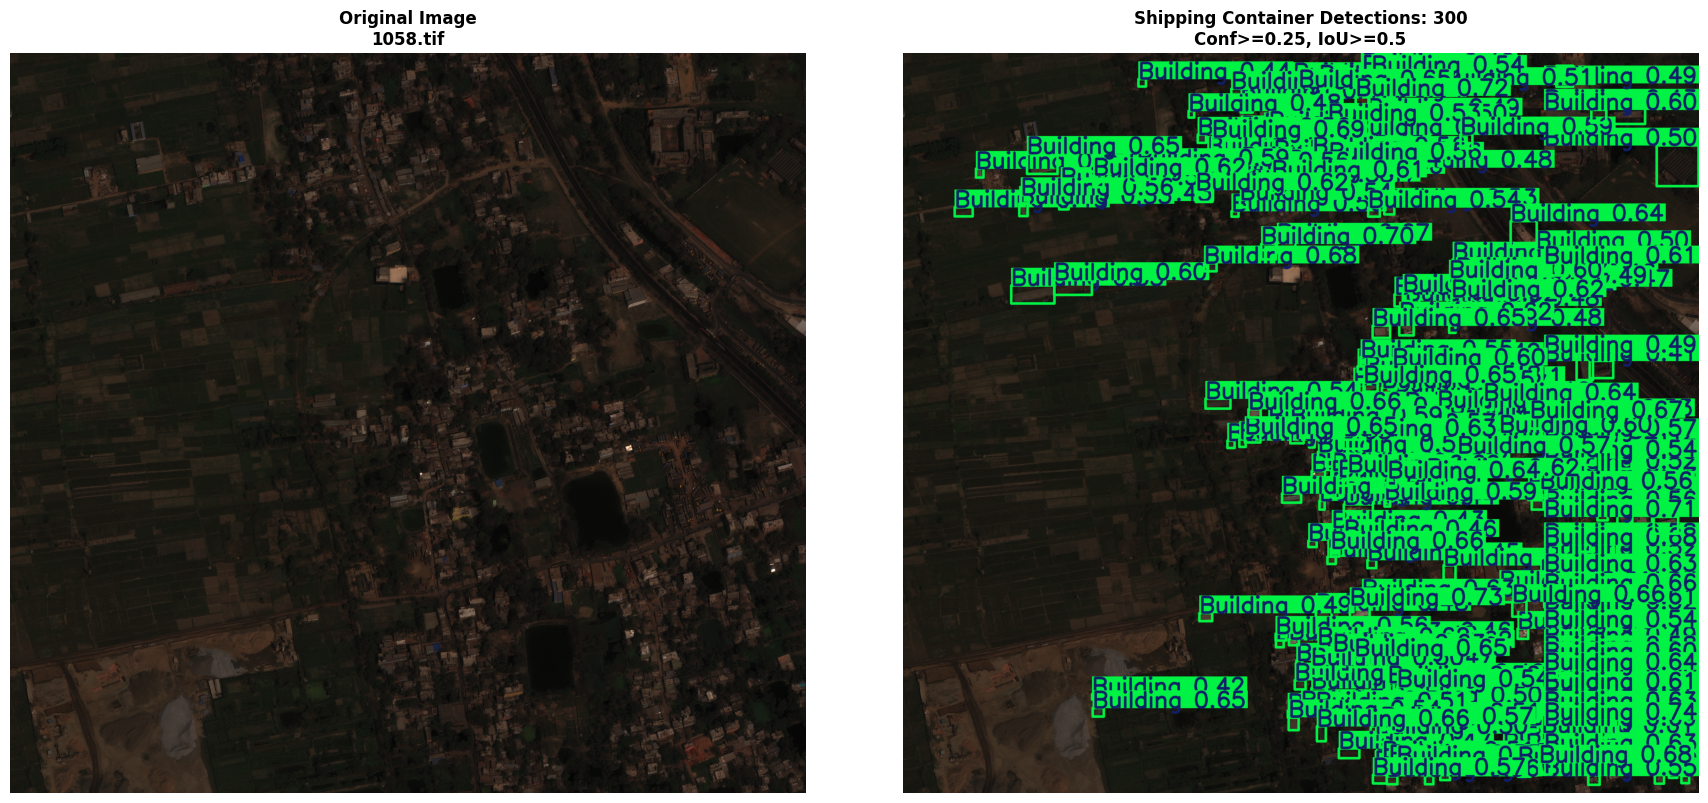


Detected 300 shipping container(s):
   1. Class: Building, Confidence: 0.736
       BBox: [x1=2572, y1=2407, x2=2636, y2=2456]
       Size: 64x50 pixels
   2. Class: Building, Confidence: 0.732
       BBox: [x1=1613, y1=1994, x2=1683, y2=2044]
       Size: 71x50 pixels
   3. Class: Building, Confidence: 0.723
       BBox: [x1=1634, y1=157, x2=1682, y2=205]
       Size: 48x48 pixels
   4. Class: Building, Confidence: 0.711
       BBox: [x1=2708, y1=1676, x2=2797, y2=1736]
       Size: 89x60 pixels
   5. Class: Building, Confidence: 0.698
       BBox: [x1=1292, y1=691, x2=1345, y2=748]
       Size: 53x56 pixels
   6. Class: Building, Confidence: 0.693
       BBox: [x1=2521, y1=2427, x2=2580, y2=2483]
       Size: 60x56 pixels
   7. Class: Building, Confidence: 0.690
       BBox: [x1=1116, y1=306, x2=1161, y2=354]
       Size: 45x48 pixels
   8. Class: Building, Confidence: 0.679
       BBox: [x1=1086, y1=762, x2=1131, y2=791]
       Size: 45x29 pixels
   9. Class: Building, Confidence: 

In [9]:
# Test on validation image with default threshold
if val_images:
    test_image = val_images[0]
    print(f"Testing on validation image: {test_image.name}")
    results = detect_and_visualize(test_image, model, conf_threshold=0.25, iou_threshold=0.5)
else:
    print("No validation images available")

# Test with lower confidence threshold to see more potential containers
if val_images:
    print("Testing with lower confidence threshold (0.15):")
    results = detect_and_visualize(val_images[0], model, conf_threshold=0.15, iou_threshold=0.5)
else:
    print("No validation images available")

Testing on second validation image: 1590.tif


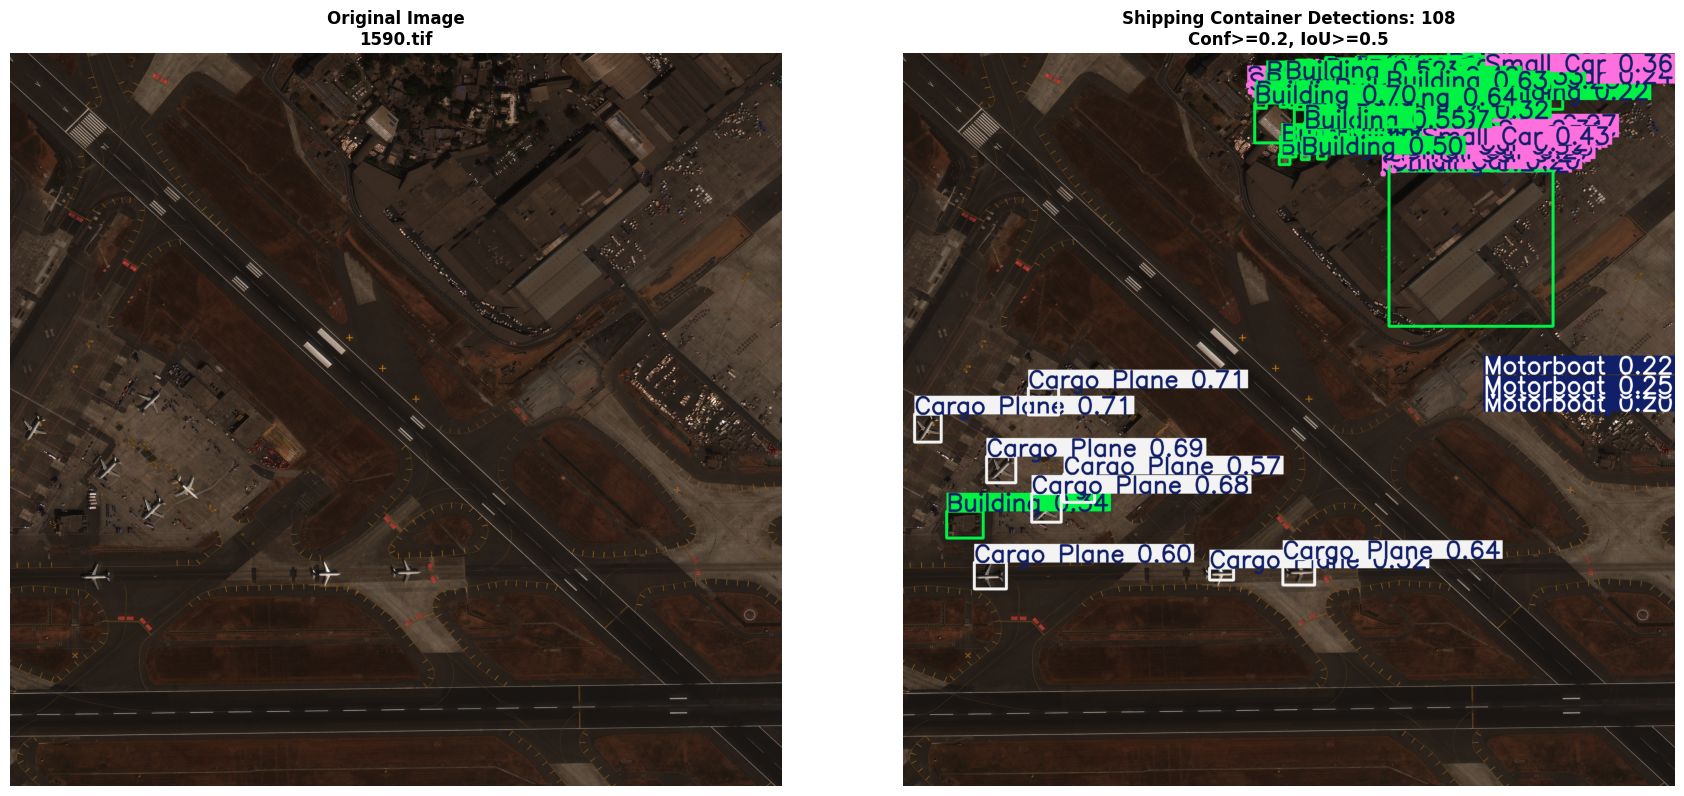


Detected 108 shipping container(s):
   1. Class: Cargo Plane, Confidence: 0.715
       BBox: [x1=481, y1=1288, x2=597, y2=1391]
       Size: 116x103 pixels
   2. Class: Cargo Plane, Confidence: 0.708
       BBox: [x1=45, y1=1389, x2=147, y2=1496]
       Size: 102x107 pixels
   3. Class: Building, Confidence: 0.702
       BBox: [x1=1349, y1=195, x2=1501, y2=349]
       Size: 152x154 pixels
   4. Class: Cargo Plane, Confidence: 0.687
       BBox: [x1=320, y1=1551, x2=433, y2=1651]
       Size: 113x100 pixels
   5. Class: Cargo Plane, Confidence: 0.679
       BBox: [x1=494, y1=1693, x2=606, y2=1802]
       Size: 113x110 pixels
   6. Class: Cargo Plane, Confidence: 0.643
       BBox: [x1=1457, y1=1942, x2=1578, y2=2043]
       Size: 122x101 pixels
   7. Class: Building, Confidence: 0.643
       BBox: [x1=1736, y1=205, x2=1850, y2=309]
       Size: 114x105 pixels
   8. Class: Building, Confidence: 0.629
       BBox: [x1=1852, y1=142, x2=1962, y2=287]
       Size: 110x146 pixels
   9. Class

In [10]:
# Test on a different validation image
if len(val_images) > 1:
    test_image = val_images[1]
    print(f"Testing on second validation image: {test_image.name}")
    results = detect_and_visualize(test_image, model, conf_threshold=0.20, iou_threshold=0.5)
else:
    print("Not enough validation images")

# Test on our custom collected satellite images
if data_images:
    test_image = data_images[0]
    print(f"Testing on custom satellite data: {test_image.name}")
    results = detect_and_visualize(test_image, model, conf_threshold=0.20, iou_threshold=0.5)
else:
    print("No custom satellite images available in data/images/")

Testing on second custom image: Shanghai_2026-01-14_sentinel2.png


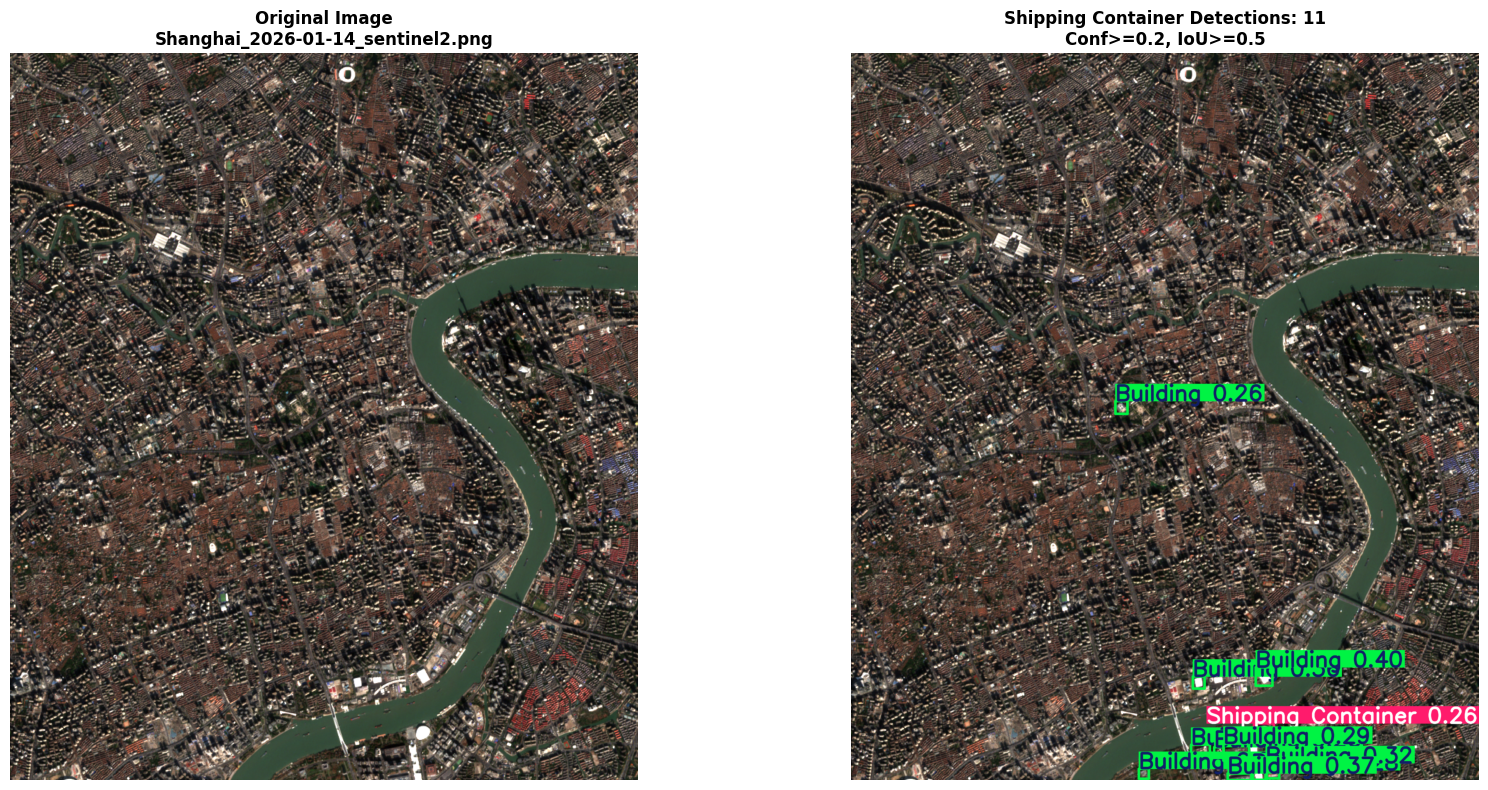


Detected 11 shipping container(s):
   1. Class: Building, Confidence: 0.397
       BBox: [x1=1139, y1=1731, x2=1187, y2=1782]
       Size: 47x52 pixels
   2. Class: Building, Confidence: 0.366
       BBox: [x1=1060, y1=2030, x2=1132, y2=2048]
       Size: 71x18 pixels
   3. Class: Building, Confidence: 0.364
       BBox: [x1=963, y1=1756, x2=995, y2=1791]
       Size: 32x35 pixels
   4. Class: Building, Confidence: 0.315
       BBox: [x1=1168, y1=2000, x2=1205, y2=2044]
       Size: 38x44 pixels
   5. Class: Building, Confidence: 0.287
       BBox: [x1=1048, y1=1946, x2=1120, y2=1994]
       Size: 72x48 pixels
   6. Class: Building, Confidence: 0.280
       BBox: [x1=1128, y1=2020, x2=1171, y2=2048]
       Size: 43x28 pixels
   7. Class: Shipping Container, Confidence: 0.265
       BBox: [x1=1134, y1=1889, x2=1191, y2=1943]
       Size: 56x54 pixels
   8. Class: Building, Confidence: 0.261
       BBox: [x1=744, y1=980, x2=779, y2=1016]
       Size: 34x36 pixels
   9. Class: Building, 

In [21]:
# Test on another custom image if available
if len(data_images) > 1:
    test_image = data_images[1]
    print(f"Testing on second custom image: {test_image.name}")
    results = detect_and_visualize(test_image, model, conf_threshold=0.20, iou_threshold=0.5)
else:
    print("Only one custom image available")

Testing specific image: image.png


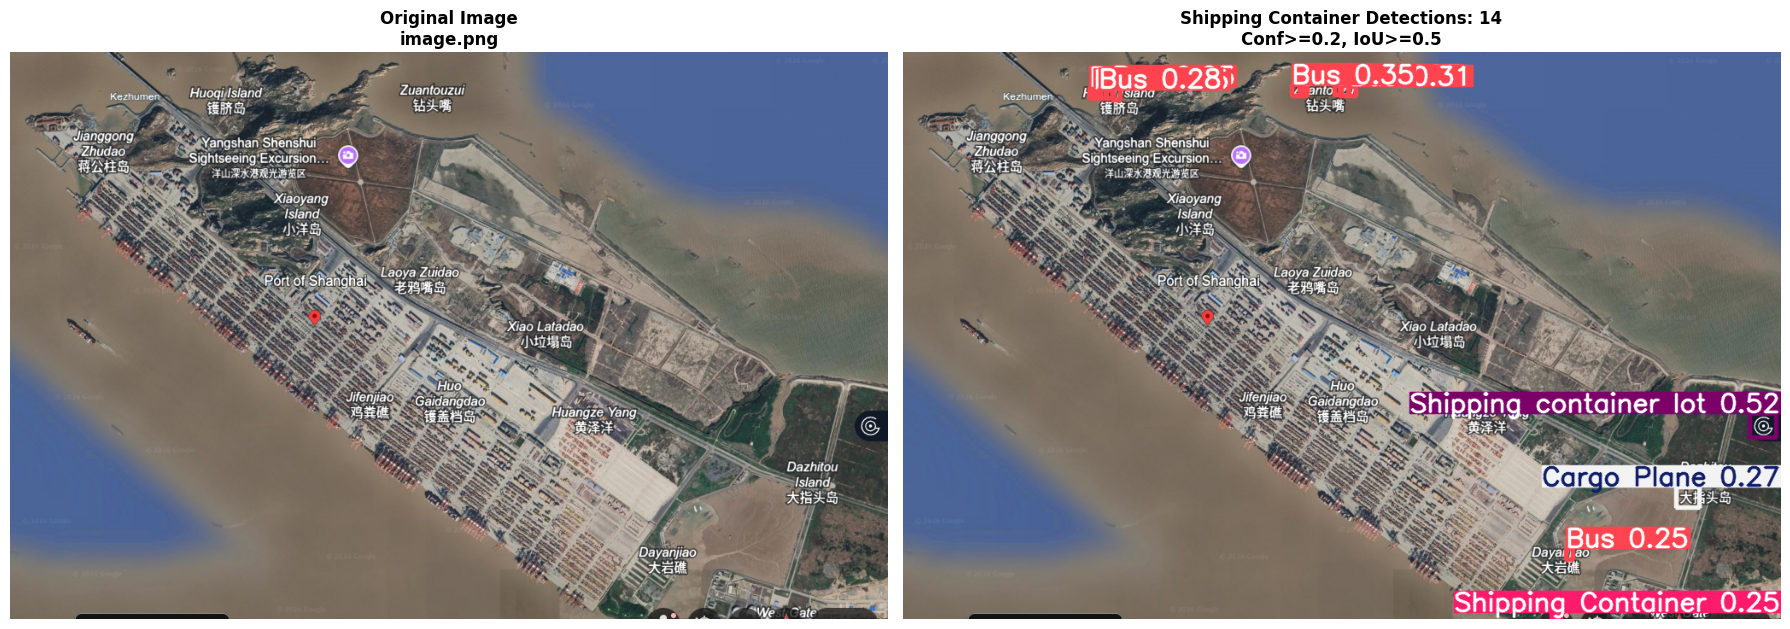


Detected 14 shipping container(s):
   1. Class: Shipping container lot, Confidence: 0.523
       BBox: [x1=992, y1=423, x2=1022, y2=452]
       Size: 30x28 pixels
   2. Class: Bus, Confidence: 0.354
       BBox: [x1=455, y1=38, x2=468, y2=51]
       Size: 13x13 pixels
   3. Class: Bus, Confidence: 0.306
       BBox: [x1=523, y1=40, x2=531, y2=51]
       Size: 8x11 pixels
   4. Class: Bus, Confidence: 0.284
       BBox: [x1=230, y1=44, x2=238, y2=55]
       Size: 8x11 pixels
   5. Class: Bus, Confidence: 0.273
       BBox: [x1=224, y1=44, x2=231, y2=54]
       Size: 7x10 pixels
   6. Class: Bus, Confidence: 0.269
       BBox: [x1=464, y1=39, x2=474, y2=51]
       Size: 10x12 pixels
   7. Class: Cargo Plane, Confidence: 0.268
       BBox: [x1=905, y1=509, x2=933, y2=534]
       Size: 27x24 pixels
   8. Class: Bus, Confidence: 0.268
       BBox: [x1=512, y1=39, x2=522, y2=52]
       Size: 10x12 pixels
   9. Class: Bus, Confidence: 0.253
       BBox: [x1=239, y1=44, x2=246, y2=55]
       

In [22]:
# Google earth real image
specific_image = Path('data/images/image.png')
if specific_image.exists():
    print(f"Testing specific image: {specific_image.name}")
    results = detect_and_visualize(specific_image, model, conf_threshold=0.20, iou_threshold=0.5)
else:
    print(f"Image not found: {specific_image}")

# Model Verification & Testing

Load the trained model and test on our satellite data

In [ ]:
# Load configuration
with open('config.json', 'r') as f:
    config = json.load(f)

# Initialize Google Earth Engine Collector
collector = GoogleEarthCollector(config_path='config.json', authenticate=False)

ports = config['ports']
print(f"Loaded {len(ports)} major ports for analysis")

## Port Locations

Let's visualize the major ports we're analyzing:

In [ ]:
# Display port information
import plotly.graph_objects as go

print("Major Ports for Container Analysis:")
print("=" * 70)
for i, port in enumerate(ports, 1):
    print(f"{i}. {port['name']:15} | {port['country']:15} | Lat: {port['lat']:7.4f}, Lon: {port['lon']:8.4f}")
print("=" * 70)

# Create world map with port locations
fig = go.Figure(data=go.Scattergeo(
    lon=[p['lon'] for p in ports],
    lat=[p['lat'] for p in ports],
    text=[f"{p['name']}<br>{p['country']}" for p in ports],
    mode='markers+text',
    marker=dict(
        size=15,
        color='red',
        line=dict(width=2, color='white')
    ),
    textposition="top center",
    textfont=dict(size=12, color='black', family='Arial Black')
))

fig.update_layout(
    title='Major Ports for Container Analysis',
    geo=dict(
        projection_type='natural earth',
        showland=True,
        landcolor='rgb(243, 243, 243)',
        coastlinecolor='rgb(204, 204, 204)',
        showcountries=True,
        countrycolor='rgb(204, 204, 204)',
    ),
    height=500,
)

fig.show()

In [ ]:
class ContainerDetector:
    def __init__(self, model_type='xview'):
        """
        Initialize container detector with satellite-specific models
        
        Args:
            model_type: 'xview' (best for satellite), 'dota' (aerial), or 'yolo-coco' (ground-level)
        """
        self.model_type = model_type
        
        if model_type == 'xview':
            # xView dataset - specifically for overhead satellite imagery
            try:
                # Try your trained xView model
                self.model = YOLO('runs/detect/train/weights/best.pt')
                print("✓ Loaded your trained xView model")
                print("  xView classes include: Container Ship, Shipping Container, Maritime Vessel")
            except:
                try:
                    # Try pre-existing xView model
                    self.model = YOLO('yolov8n-xview.pt')
                    print("✓ Loaded YOLOv8 trained on xView dataset")
                except:
                    print("⚠️  xView model not found")
                    print("   Train one with: model.train(data='xView.yaml', epochs=100)")
                    print("   Falling back to OBB model...")
                    self.model = YOLO('runs/obb/train/weights/best.pt')
                    self.model_type = 'dota'
        elif model_type == 'dota':
            # DOTA dataset for aerial imagery
            try:
                self.model = YOLO('runs/obb/train/weights/best.pt')
                print("✓ Loaded your trained DOTA OBB model")
            except:
                self.model = YOLO('yolov8n.pt')
                self.model_type = 'yolo-optimized'
        else:
            # Standard COCO-trained model
            self.model = YOLO('yolov8n.pt')
            print("✓ Loaded standard YOLOv8 (COCO dataset)")
        
        # Print available classes
        print(f"  Model classes ({len(self.model.names)}): {list(self.model.names.values())[:10]}...")
    
    def preprocess_image(self, image_path):
        """Preprocess satellite image for container detection"""
        img = cv2.imread(str(image_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # For satellite imagery, enhance contrast
        if self.model_type in ['xview', 'dota', 'yolo-optimized']:
            # Convert to LAB color space for better contrast
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            
            # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
            l = clahe.apply(l)
            
            # Merge and convert back
            enhanced = cv2.merge([l, a, b])
            img = cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)
        
        return img
    
    def detect_containers(self, image, show_all_classes=False):
        """Detect and count containers in satellite image"""
        
        # Define container-related classes for xView dataset
        xview_container_classes = [
            'Container Ship',       # Class 31
            'Shipping Container',   # Class 57
            'Shipping container lot', # Class 56
            'Container Crane',      # Class 35
            'Cargo Ship',          # Class 2
            'Cargo Plane',         # Class 2
            'Cargo Truck',         # Class 10
            'Cargo Car',           # Class 19
            'Maritime Vessel',     # Class 23
            'Barge',               # Class 27
            'Crane Truck',         # Class 16
            'Reach Stacker',       # Class 36
            'Straddle Carrier'     # Class 37
        ]
        
        if self.model_type == 'xview':
            conf_threshold = 0.15  # Reasonable threshold for xView
            container_classes = xview_container_classes
        elif self.model_type == 'dota':
            conf_threshold = 0.10
            container_classes = list(self.model.names.values())
        else:
            conf_threshold = 0.05
            container_classes = [2, 5, 7, 8]  # car, bus, truck, boat for COCO
        
        # Use higher image size for better detection
        results = self.model(image, conf=conf_threshold, verbose=False, imgsz=1280)
        
        containers = []
        all_detections = []
        
        for result in results:
            boxes = result.boxes if hasattr(result, 'boxes') else result.obb
            if boxes is not None:
                for box in boxes:
                    cls = int(box.cls)
                    conf = float(box.conf)
                    class_name = self.model.names[cls]
                    
                    # Track all detections for analysis
                    all_detections.append({
                        'class_id': cls,
                        'class_name': class_name,
                        'confidence': conf
                    })
                    
                    # Filter for container-like objects
                    is_container = False
                    if self.model_type == 'xview':
                        is_container = class_name in container_classes
                    elif self.model_type == 'dota':
                        is_container = True  # Accept all DOTA classes
                    else:
                        is_container = cls in container_classes
                    
                    if is_container and conf > conf_threshold:
                        containers.append({
                            'bbox': box.xyxy.cpu().numpy() if hasattr(box, 'xyxy') else box.xywhr.cpu().numpy(),
                            'confidence': conf,
                            'class': cls,
                            'class_name': class_name
                        })
        
        if show_all_classes:
            return len(containers), containers, all_detections
        return len(containers), containers
    
    def analyze_port_activity(self, image_dir, port_name):
        """Analyze container activity for a specific port"""
        image_files = list(Path(image_dir).glob('*.jp*g')) + list(Path(image_dir).glob('*.png'))
        results = []
        
        for img_path in image_files:
            img = self.preprocess_image(img_path)
            count, detections = self.detect_containers(img)
            
            results.append({
                'port': port_name,
                'image': img_path.name,
                'container_count': count,
                'timestamp': datetime.now()
            })
        
        return pd.DataFrame(results)

In [ ]:
class TradingSignalGenerator:
    def __init__(self):
        self.container_data = pd.DataFrame()
        
    def load_container_data(self, data):
        """Load container count data"""
        self.container_data = data
        
    def calculate_signals(self):
        """Generate trading signals from container volume changes"""
        if self.container_data.empty:
            return pd.DataFrame()
        
        # Group by port and calculate rolling statistics
        signals = []
        
        for port in self.container_data['port'].unique():
            port_data = self.container_data[self.container_data['port'] == port].copy()
            port_data = port_data.sort_values('timestamp')
            
            # Calculate moving averages and changes
            port_data['ma_7'] = port_data['container_count'].rolling(7).mean()
            port_data['ma_30'] = port_data['container_count'].rolling(30).mean()
            port_data['pct_change'] = port_data['container_count'].pct_change()
            
            # Generate signals
            port_data['signal'] = 0
            port_data.loc[port_data['ma_7'] > port_data['ma_30'], 'signal'] = 1  # Bullish
            port_data.loc[port_data['ma_7'] < port_data['ma_30'], 'signal'] = -1  # Bearish
            
            # Warning signal for extremely high volumes
            high_threshold = port_data['container_count'].quantile(0.95)
            port_data['warning'] = port_data['container_count'] > high_threshold
            
            signals.append(port_data)
        
        return pd.concat(signals, ignore_index=True)
    
    def generate_global_signal(self, port_signals):
        """Generate global trading signal from all ports"""
        global_signal = port_signals.groupby('timestamp').agg({
            'container_count': 'sum',
            'signal': 'mean',
            'warning': 'any'
        }).reset_index()
        
        global_signal['global_signal'] = np.where(
            global_signal['signal'] > 0.2, 1,
            np.where(global_signal['signal'] < -0.2, -1, 0)
        )
        
        return global_signal

In [ ]:
# Initialize detector and signal generator
detector = ContainerDetector(model_type='dota')
signal_gen = TradingSignalGenerator()

print("✓ Container detector initialized")
print("✓ Trading signal generator initialized")

## Install DOTA-Trained Model

Three options to get satellite-specific detection:

In [ ]:
# Download satellite images using GoogleEarthCollector
shanghai = ports[0]  # Shanghai port
print(f"\nDownloading imagery of {shanghai['name']} port...")
print(f"Using Google Earth Engine with Sentinel-2 satellite")

# Download images using GEE collector
downloaded_df = collector.collect_port_images(
    port_name=shanghai['name'],
    days_back=30,
    max_images=10,
    max_cloud=10,
    source='sentinel2'
)

if not downloaded_df.empty:
    print(f"\n✓ Downloaded {len(downloaded_df)} images")
    
    # Convert DataFrame to list format for compatibility with visualization code
    downloaded = [
        {
            'port': row['port'],
            'filepath': Path(row['filepath']),
            'date': row['date']
        }
        for _, row in downloaded_df.iterrows()
    ]
else:
    print("No images downloaded")
    downloaded = []

## Sample Image Download and Visualization

Now let's download actual satellite images and visualize them:

In [ ]:
# Visualize ALL downloaded images
if 'downloaded' in dir() and len(downloaded) > 0:
    print(f"\n{'='*70}")
    print(f"Downloaded {len(downloaded)} satellite images for {shanghai['name']}")
    print(f"{'='*70}\n")
    
    # Calculate grid dimensions for all images
    n_images = len(downloaded)
    n_cols = min(5, n_images)  # Max 5 columns
    n_rows = (n_images + n_cols - 1) // n_cols  # Ceiling division
    
    # Create grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
    
    # Flatten axes array for easy iteration
    if n_images == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_rows > 1 else axes
    
    # Display all images
    for idx, img_info in enumerate(downloaded):
        img = Image.open(img_info['filepath'])
        axes[idx].imshow(img)
        axes[idx].set_title(f"{img_info['port']}\n{img_info['date']}", 
                           fontsize=10, fontweight='bold')
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(n_images, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'Sentinel-2 Satellite Imagery - {shanghai["name"]} Port ({n_images} images)', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print detailed summary
    print(f"\n Image Summary:")
    print(f"  • Total images: {n_images}")
    print(f"  • Date range: {downloaded[0]['date']} to {downloaded[-1]['date']}")
    print(f"\n Image Details:")
    for i, img_info in enumerate(downloaded, 1):
        print(f"  {i:2d}. {img_info['date']} - {img_info['filepath'].name}")
else:
    print(" No images downloaded yet. Run the previous cell first.")

In [ ]:
# Inference on all downloaded satellite images using trained OBB model
from ultralytics import YOLO
from pathlib import Path
import pandas as pd

# Load the best trained OBB model
model = YOLO("runs/obb/train/weights/best.pt")

# Directory containing satellite images
image_dir = Path("data/images")
# GEE collector saves images as .png files
image_files = list(image_dir.glob("*.png")) + list(image_dir.glob("*.jpg"))

if not image_files:
    print(f"No images found in {image_dir}")
    print("Please run the image download cell first (Cell 10)")
else:
    print(f"Found {len(image_files)} images to process\n")
    
    results_list = []
    
    for img_path in image_files:
        try:
            results = model(str(img_path))
            # Get results as DataFrame
            result_data = results[0].to_df()
            
            # Handle both polars and pandas DataFrames
            if hasattr(result_data, "to_pandas"):
                df = result_data.to_pandas()
            else:
                df = pd.DataFrame(result_data)
            
            df["image"] = img_path.name
            results_list.append(df)
            print(f"✓ Processed {img_path.name} - {len(df)} detections")
        except Exception as e:
            print(f"✗ Error processing {img_path.name}: {e}")
    
    # Combine all results into a single DataFrame
    if results_list:
        all_detections = pd.concat(results_list, ignore_index=True)
        print("\nDetection results for all images:")
        print(all_detections.head())
        
        # Save to CSV
        Path("data/results").mkdir(parents=True, exist_ok=True)
        all_detections.to_csv("data/results/obb_detections.csv", index=False)
        print(f"\n✓ All detection results saved to data/results/obb_detections.csv")
        print(f"✓ Total detections: {len(all_detections)}")
    else:
        print("\n No detections made from any images")

## Container Detection on Downloaded Images

Apply YOLO model to detect containers in the satellite images:

In [ ]:
# Run container detection on downloaded images
if 'downloaded' in dir() and len(downloaded) > 0:
    print("Running YOLO container detection...")
    print("NOTE: YOLO is trained on ground photos, not satellite imagery!")
    print("=" * 70)
    
    detection_results = []
    all_classes_found = {}
    
    for img_info in downloaded:
        # Load and preprocess image
        img = detector.preprocess_image(img_info['filepath'])
        
        # Detect containers and get all detections
        count, detections, all_dets = detector.detect_containers(img, show_all_classes=True)
        
        # Track what classes were found
        for det in all_dets:
            class_name = det['class_name']
            if class_name not in all_classes_found:
                all_classes_found[class_name] = 0
            all_classes_found[class_name] += 1
        
        detection_results.append({
            'port': img_info['port'],
            'date': img_info['date'],
            'filepath': img_info['filepath'],
            'container_count': count,
            'detections': detections,
            'all_detections': all_dets
        })
        
        print(f"✓ {img_info['date']}: {count:3d} vehicles | {len(all_dets):3d} total objects")
    
    print("=" * 70)
    
    # Show what YOLO actually detected
    print(f"\nAll Object Classes Detected (across all {len(downloaded)} images):")
    if all_classes_found:
        for class_name, count in sorted(all_classes_found.items(), key=lambda x: x[1], reverse=True):
            print(f"  • {class_name:20s}: {count:4d} instances")
    else:
        print("  No objects detected at all!")
        print("  This is because:")
        print("    - Satellite images are taken from 700km altitude")
        print("    - YOLO expects ground-level photos (0-100m)")
        print("    - Objects are too small (< 5 pixels)")
    
    # Visualize detections on image with most detections
    if detection_results:
        # Find image with most detections
        best_result = max(detection_results, key=lambda x: len(x['all_detections']))
        
        img = cv2.imread(str(best_result['filepath']))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Draw ALL detections (not just vehicles)
        for det in best_result['all_detections'][:50]:  # Limit to 50 for clarity
            # Find bounding boxes from the model results
            pass
        
        # Draw vehicle detections with boxes
        for det in best_result['detections']:
            bbox = det['bbox'][0]
            x1, y1, x2, y2 = map(int, bbox)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
            label = f"{det['class_name']} {det['confidence']:.2f}"
            cv2.putText(img, label, (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        
        # Display
        plt.figure(figsize=(14, 10))
        plt.imshow(img)
        plt.title(f"Best Detection Result - {best_result['port']} ({best_result['date']})\n{best_result['container_count']} vehicles | {len(best_result['all_detections'])} total objects", 
                 fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        total_vehicles = sum(r['container_count'] for r in detection_results)
        total_objects = sum(len(r['all_detections']) for r in detection_results)
        print(f"\nDetection Summary:")
        print(f"  • Total vehicles detected: {total_vehicles} (across {len(detection_results)} images)")
        print(f"  • Total objects detected: {total_objects}")
        print(f"  • Average per image: {total_vehicles/len(detection_results):.1f} vehicles, {total_objects/len(detection_results):.1f} objects")
        
        if total_vehicles == 0:
            print(f"\nRecommendation:")
            print(f"  For satellite imagery, you need:")
            print(f"  1. Models trained on aerial/satellite data (not COCO)")
            print(f"  2. Higher resolution images (4096x4096 or larger)")
            print(f"  3. Specialized container detection models")
            print(f"  4. Or use synthetic data for demonstration (next cell)")
else:
    print("⚠️  No images available for detection. Download images first.")

## Trading Signal Generation

Generate trading signals from container volume analysis:

In [ ]:
# Generate trading signals
signal_gen.load_container_data(df_containers)
port_signals = signal_gen.calculate_signals()
global_signals = signal_gen.generate_global_signal(port_signals)

print("Trading signals generated:")
print(global_signals.tail())

In [ ]:
# Visualization
print("\nGenerating trading signal visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Container counts by port
print("  • Plotting container counts by port...")
for port in ports:
    port_data = df_containers[df_containers['port'] == port['name']]
    axes[0,0].plot(port_data['timestamp'], port_data['container_count'], 
                   label=f"{port['name']} ({port['country']})", marker='o', markersize=3)
axes[0,0].set_title('Container Counts by Port', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Date', fontsize=11)
axes[0,0].set_ylabel('Container Count', fontsize=11)
axes[0,0].legend(loc='best', fontsize=9)
axes[0,0].grid(True, alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

# Global container volume
print("  • Plotting global container volume...")
axes[0,1].plot(global_signals['timestamp'], global_signals['container_count'], 
               color='blue', linewidth=2, marker='o', markersize=4)
axes[0,1].set_title('Global Container Volume (All Ports)', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Date', fontsize=11)
axes[0,1].set_ylabel('Total Container Count', fontsize=11)
axes[0,1].grid(True, alpha=0.3)
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].fill_between(global_signals['timestamp'], global_signals['container_count'], 
                        alpha=0.3, color='blue')

# Trading signals
print("  • Plotting trading signals...")
signal_colors = {1: 'green', -1: 'red', 0: 'gray'}
for signal_val, color in signal_colors.items():
    mask = global_signals['global_signal'] == signal_val
    axes[1,0].scatter(global_signals[mask]['timestamp'], 
                     global_signals[mask]['global_signal'],
                     c=color, s=100, alpha=0.7, 
                     label=f"{'Buy' if signal_val == 1 else 'Sell' if signal_val == -1 else 'Hold'}")
axes[1,0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1,0].set_title('Global Trading Signal', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Date', fontsize=11)
axes[1,0].set_ylabel('Signal (-1: Sell, 0: Hold, 1: Buy)', fontsize=11)
axes[1,0].set_ylim(-1.5, 1.5)
axes[1,0].grid(True, alpha=0.3)
axes[1,0].legend(loc='best')
axes[1,0].tick_params(axis='x', rotation=45)

# Warning signals
print("  • Plotting warning signals...")
warning_dates = global_signals[global_signals['warning']]['timestamp']
normal_dates = global_signals[~global_signals['warning']]['timestamp']
axes[1,1].scatter(warning_dates, [1]*len(warning_dates), 
                 color='red', s=150, alpha=0.8, marker='X', label='High Volume Warning')
axes[1,1].scatter(normal_dates, [0]*len(normal_dates), 
                 color='green', s=50, alpha=0.5, marker='o', label='Normal Volume')
axes[1,1].set_title('High Volume Warning Signals', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Date', fontsize=11)
axes[1,1].set_ylabel('Status', fontsize=11)
axes[1,1].set_ylim(-0.5, 1.5)
axes[1,1].set_yticks([0, 1])
axes[1,1].set_yticklabels(['Normal', 'Warning'])
axes[1,1].grid(True, alpha=0.3)
axes[1,1].legend(loc='best')
axes[1,1].tick_params(axis='x', rotation=45)

plt.suptitle('Satellite Container Analysis - Trading Dashboard', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n✓ Visualizations complete!")

In [ ]:
# Save results
output_dir = Path('data/results')
output_dir.mkdir(parents=True, exist_ok=True)

# Save container data and signals
df_containers.to_csv(output_dir / 'container_counts.csv', index=False)
port_signals.to_csv(output_dir / 'port_signals.csv', index=False)
global_signals.to_csv(output_dir / 'global_signals.csv', index=False)

print(f"Results saved to {output_dir}")
print(f"\nSummary:")
print(f"- Total observations: {len(df_containers)}")
print(f"- Ports analyzed: {df_containers['port'].nunique()}")
print(f"- Date range: {df_containers['timestamp'].min()} to {df_containers['timestamp'].max()}")
print(f"- Average daily global volume: {global_signals['container_count'].mean():.0f} containers")